In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
import warnings
warnings.filterwarnings('ignore')
np.random.seed(25)
tf.executing_eagerly()

False

Getting the data

In [11]:
labels_path = '/content/drive/MyDrive/dog-breed-identification/labels.csv'
labels_df = pd.read_csv(labels_path)
print(labels_df['breed'].value_counts())

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


In [12]:
#Selecting only the top 30 breeds

top_breeds = sorted(list(labels_df['breed'].value_counts().head(30).index))
labels_df = labels_df[labels_df['breed'].isin(top_breeds)]
labels_df['breed'].unique()

array(['basenji', 'scottish_deerhound', 'maltese_dog', 'lakeland_terrier',
       'cairn', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu',
       'australian_terrier', 'samoyed', 'papillon', 'entlebucher',
       'saluki', 'pug', 'airedale', 'leonberg', 'bernese_mountain_dog',
       'italian_greyhound', 'afghan_hound', 'miniature_pinscher',
       'irish_wolfhound', 'chow', 'siberian_husky', 'great_pyrenees',
       'beagle', 'whippet', 'japanese_spaniel', 'pomeranian', 'pembroke',
       'blenheim_spaniel'], dtype=object)

Generating train dataset

In [13]:

train_path = "/content/drive/MyDrive/dog-breed-identification/train/"
test_path = "/content/drive/MyDrive/dog-breed-identification/test/"

img_dim = 64

labels_df['image_path'] = labels_df.apply(lambda x: (train_path + x["id"] + ".jpg" ), axis=1 )
train_data = np.array([img_to_array(load_img(img, target_size=(img_dim, img_dim))) for img in labels_df['image_path'].values.tolist()])
train_labels = labels_df['breed']

X_train = (train_data/255).astype('float32')
y_train = train_labels

print(X_train.shape)
print(y_train.shape)

#np.save("x_train_dgs.npy", X_train)

(3134, 64, 64, 3)
(3134,)


In [14]:
img_height   = X_train.shape[1]   
img_width    = X_train.shape[2]    
num_channels = X_train.shape[3]    
input_shape =  (img_height, img_width, num_channels)   
latent_dim = 128

Encoder Architecture

In [15]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=128, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=256, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=512, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)

sigma = Dense(latent_dim)(encoder)

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
conv_shape = K.int_shape(encoder_conv)

Decoder Architecture

In [16]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=512, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=256, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

Creating the Model

In [17]:
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

vae = Model(encoder_input, decoder(encoder(encoder_input)))

Loss Function and Compiling

In [18]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = K.sum(K.square(true-pred), axis=[1,2,3])
  # KL divergence loss
  kl_loss = - 0.5 * K.sum(1 + 2*sigma - K.square(mu) - K.square(K.exp(sigma)), axis=-1)
  return  reconstruction_loss + 1*kl_loss


vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

Training

In [20]:
history = vae.fit(x=X_train, y=X_train, epochs=100, batch_size=32, validation_data=(X_train,X_train))

Train on 3134 samples, validate on 3134 samples
Epoch 1/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 406.6805 - val_loss: 396.4533
Epoch 2/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 399.1254 - val_loss: 392.0790
Epoch 3/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 395.2692 - val_loss: 384.3324
Epoch 4/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 390.3633 - val_loss: 381.4434
Epoch 5/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 386.4658 - val_loss: 376.4416
Epoch 6/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 380.3231 - val_loss: 371.9076
Epoch 7/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 376.9735 - val_loss: 371.8447
Epoch 8/100
3134/3134 [==============================] - 26s 8ms/sample - loss: 373.1335 - val_loss: 365.3260
Epoch 9/100
3134/3134 [==============================] - 26s 8ms/sample 

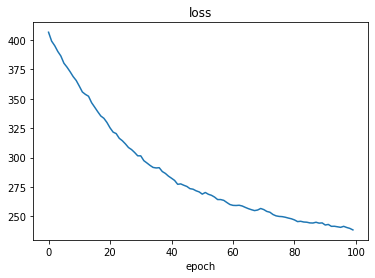

In [21]:
plt.plot(history.history['loss'])
plt.title("loss")
plt.xlabel('epoch')
plt.show()

Predicting Images

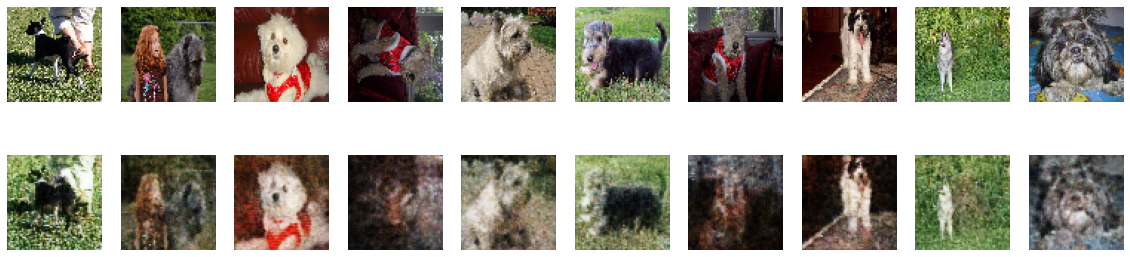

In [22]:
plt.figure(figsize=(20,5))
X_pred = vae.predict(X_train[:10])

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,10+i+1)
    plt.imshow(X_pred[i])
    plt.axis('off')


  Generating random images utilizing decoder

In [23]:
encoded = encoder.predict(X_train)
encoded.shape

#shape is (n_of_samples x latent_dim)

(3134, 128)

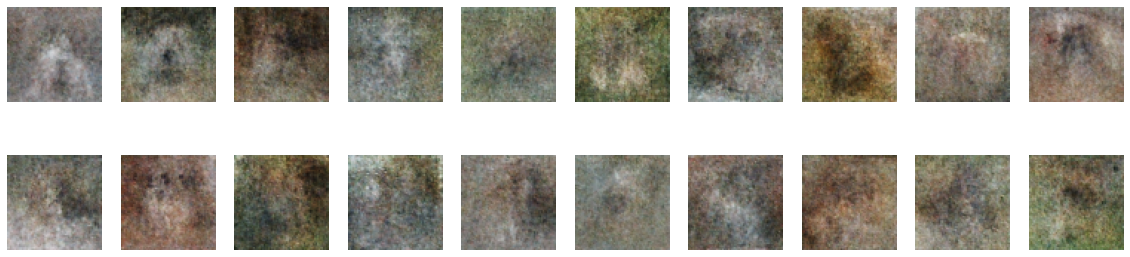

In [24]:
#size = (n_of_samples x latent_dim)
rand_data = np.random.normal(size = 20 * latent_dim).reshape(-1, latent_dim)
new_images = decoder.predict(rand_data)

plt.figure(figsize=(20,5))
for i, dog in enumerate(new_images):
    plt.subplot(2,10,i+1)
    plt.imshow(dog)
    plt.axis('off')